# Lab 2
## Medical Patient No Show

### Team members: Luay Dajani, Dana Geislinger, Chris Morgan, Caroll Rodriguez
##### Github - https://github.com/cdmorgan103/7331DataMiningNoShow

MSDS 7331, 10/28/2018

#### Resubmission:

Modeling and Evaluation 2 - added discussion on TimeSerierSplit()

Modeling and Evaluation 4 - added missing analysis

Modeling and Evaluation 6 - executed code and added analysis and ROC

Deployment - completed section

In [1]:
import numpy as np
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
from IPython.display import display
import seaborn as sns; sns.set(font_scale=1.2)
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit 
import datetime 
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load the data into variable 'df' from pickled object
from funcs import load_df
df = load_df()

## Data Preparation Part 1


#### Load and Prepare Dataset
We are using the same dataset from Lab1 and the minilab for the purposes of predicting noshow to clinical appointments. The dataset includes the additional created variables of age_range,  the split of date/time from Scheduled Day for deeper analysis, Scheduled day of week, Appointment day of week and days in advance the appointment was scheduled.

In [2]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null bool
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null category
AppointmentDOW    110527 non-null category
age_range         110527 non-null category
dtypes: bool(1), category(5), datetime64[ns](2), int64(10), object(1)
memory usage: 11.6+ MB


##### *Note on Date/Time*
SciKitLearn models have difficulty working with complex objects such as datetime.datetime and datetime.time. To account for this, we will store all dates as ordinal values (the number of days since 1/1/1) and all time values as the number of elapsed seconds in the day (1:30PM = 13 * 3600 + 30 * 60).

In [3]:
# Convert date columns to ordinal integer values (days since 1/1/1)
dt_ord = lambda dt: dt.toordinal()
if 'ScheduledDay' in df:
    df['ScheduledDayOrdinal'] = df['ScheduledDay'].apply(dt_ord)
if 'AppointmentDay' in df:
    df['AppointmentDayOrdinal'] = df['AppointmentDay'].apply(dt_ord)

# Convert time values to seconds (total seconds since start of day)
to_secs = lambda t: t.hour * 3600 + t.minute * 60 + t.second
if 'ScheduledTime' in df:
    df['ScheduledTimeSeconds'] = df['ScheduledTime'].apply(to_secs)

Next we will create dummy variables for our datsets class variables Handicap, AppointmentDOW, Scheduled DOW, Neighbourhood, and age range. We will also create the variable "ismale" to make dummy classification easier for gender.

In [4]:
#Remove attributes not usefull

del df['PatientId']
del df['AppointmentID']

# perform one-hot encoding of the categorical data 
tmp_df = pd.get_dummies(df.Handicap,prefix='Handicap')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.AppointmentDOW,prefix='AppointmentDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.ScheduledDOW,prefix='ScheduledDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.Neighbourhood,prefix='Neighbourhood')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.age_range,prefix='age_range')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# replace the current Gender attribute with something slightly more intuitive and readable
df['IsMale'] = df.Gender=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Now let's clean up the dataset
if 'Gender' in df:
    del df['Gender'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Handicap' in df:    
    del df['Handicap'] # get rid of the original category as it is now one-hot encoded
    
if 'ScheduledDOW' in df:    
    del df['ScheduledDOW'] # get rid of the original category as it is now one-hot encoded
    
if 'AppointmentDOW' in df:    
    del df['AppointmentDOW'] # get rid of the original category as it is now one-hot encoded

if 'Neighbourhood' in df:    
    del df['Neighbourhood'] # get rid of the original category as it is now one-hot encoded

if 'age_range' in df:
    del df['age_range']

if 'AppointmentID' in df:
    del df['AppointmentID']
    
if 'ScheduledDay' in df:
    del df['ScheduledDay']
    
if 'ScheduledTime' in df:
    del df['ScheduledTime']

if 'AppointmentDay' in df:
    del df['AppointmentDay']

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Columns: 115 entries, Age to IsMale
dtypes: bool(1), int32(1), int64(10), uint8(103)
memory usage: 19.8 MB


## Data Preparation Part 2


#### Final dataset

After removing the unnecessary variables and creating data variables, we're left with this final data set in the table below which describes each variable we will be using for classification & regression.



| Variable Name  | Data Type | Variable Type         | Description                                                             |
| -------------- | --------- | --------------------- | ----------------------------------------------------------------------- |
| PatientID      | Interval  | Identifier            | Unique ID number for each patient.                                      |
| AppointmentID  | Interval  | Identifier            | Unique ID number for each appointment.                                  |
| Gender         | Nominal   | Binary Predictor      | Sex of the patient (Male/Female).                                       |
| ScheduledDay   | Interval  | Date/Time Predictor   | **Date** and **Time** when the patient called to schedule their appointment. Should always be before *AppointmentDay*.                                                                         |
| AppointmentDay | Interval  | Date Predictor        | Scheduled appointment **Date**. Appointment **Times** are not provided. |
| Age            | Ratio     | Integer Predictor     | Age of the patient in years.                                            |
| Neighbourhood  | Nominal   | Categorical Predictor | The neighborhood in which the appointment facility is located.          |
| Scholarship    | Ordinal   | Boolean Predictor     | Whether or not the patient receives Bolsa Família financial aid. To receive this benefit, a patient's income must be under the poverty threshold, all children in the household must be vaccinated and regularly attending school, and mothers and children must receive routine medical care.                                    |
| Hipertension   | Ordinal   | Boolean Predictor     | Whether or not a patient is classified as hypertensive (has high blood pressure).                                                                                                                     |
| Diabetes       | Ordinal   | Boolean Predictor     | Whether or not a patient is diagnosed as a diabetic.                    |
| Alcoholism     | Ordinal   | Boolean Predictor     | Whether or not a patient is classified as an alcoholic.                 |
| Handcap        | Ordinal   | Boolean Predictor     | Whether or not a patient is diagnosed as being handicapped.             |
| SMS_received   | Nominal   | Boolean Predictor     | Whether or not a patient received an SMS (text message) reminder for   their appointment.                                                                                                             |
| No-show        | Nominal   | Boolean Response      | Whether or not a patient showed up for their appointment. True means they **did not** show up, False means they **did** show up.                                                                         |

#### Created Variables
| Variable Name  | Data Type | Variable Type         | Description                                                             |
| -------------- | --------- | --------------------- | ----------------------------------------------------------------------- |
| DaysInAdvance  | Ratio     | Integer Predictor     | Value for how many days in advance the appointment was scheduled.       |
| ScheduledDOW   | Nominal   | Categorical Predictor | Day of the week for the day the patient scheduled the appointment.      |
| AppointmentDOW | Nominal   | Categorical Predictor | Day of the week for patient appointment.                                |
| ScheduledTime  | Interval  | Time Predictor        | **Time** of day when an appointment was scheduled.                      |
| age_range | Nominal   | Categorical Predictor | Age grouping of patient consisting of child (0-17), Adult (18-65), & senior (66+).

This dataset contains 110,527 appointment records for clinics located across the coastal city of Vitória in Espírito Santo, Brazil. The dataset includes 11 meaningful predictors relating to each appointment and to the patient that scheduled that appointment. Unique numeric identifiers are provided for each patient as well as for each appointment. The response variable of interest for this data set, No-show, is a boolean variable denoting whether or not a patient made it to their scheduled appointment.

In [5]:
print(df.dtypes)

Age                               int64
Scholarship                       int64
Hypertension                      int64
Diabetes                          int64
Alcoholism                        int64
SMSReceived                       int64
NoShow                             bool
DaysInAdvance                     int64
ScheduledDayOrdinal               int64
AppointmentDayOrdinal             int64
ScheduledTimeSeconds              int64
Handicap_0                        uint8
Handicap_1                        uint8
Handicap_2                        uint8
Handicap_3                        uint8
Handicap_4                        uint8
AppointmentDOW_Monday             uint8
AppointmentDOW_Tuesday            uint8
AppointmentDOW_Wednesday          uint8
AppointmentDOW_Thursday           uint8
AppointmentDOW_Friday             uint8
AppointmentDOW_Saturday           uint8
AppointmentDOW_Sunday             uint8
ScheduledDOW_Monday               uint8
ScheduledDOW_Tuesday              uint8


In [6]:
df.describe()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,DaysInAdvance,ScheduledDayOrdinal,AppointmentDayOrdinal,ScheduledTimeSeconds,...,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,age_range_child,age_range_adult,age_range_senior,IsMale
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,...,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.089218,0.098266,0.197246,0.071865,0.030400,0.321026,10.183792,736092.856370,736103.040162,40557.666643,...,0.016611,0.017887,0.022148,0.028337,0.001375,0.007699,0.234060,0.645598,0.120342,0.350023
std,23.109921,0.297675,0.397921,0.258265,0.171686,0.466873,15.254924,19.140133,12.189325,11578.064436,...,0.127811,0.132541,0.147167,0.165934,0.037059,0.087409,0.423412,0.478334,0.325362,0.476979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,735912.000000,736083.000000,22176.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,736083.000000,736093.000000,30338.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,736094.000000,736102.000000,37983.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,736104.000000,736115.000000,50382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000,736123.000000,736123.000000,77255.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
#simple export of final dataset
df.to_csv("./data/df.csv", sep=',')

## Modeling and Evaluation 1

Given the nature of no-show appointments and how they can impact business practicess, we must be cautious in how we score our models performance. 

If we were to purely prioritize accuracy, it is possible to get a optimal accuracy value with no precision relatively easily using some forms of SVM modeling with the linear kernel. This was noticed in the minilab and in practice the model predicted all patients as "show". While technically the best accuracy focused model, this has no business value.

If we were to purely prioritize model precision however, we may find ourselves in an equally troubled situation.  A model with higher precision is desirable as it will allow us to effectively predict No-show patients with a greater degree of certainty. However, if our increased precision comes at the expense of creating too many false negative no-show patients (or a show patient who was predicted as no-show).

Because of this, we need to balance a reasonable model yield that could be actionable with not creating to many false negative predictions. Therefore F1 score is likely the strongest metric for us to focus on as it will allow for a balance between precision and recall, and with the large amount of actual negatives (show patients), a F1 score is a reasonable metric to prioritize. It is critical to still consider total accuracy, precision, recall, and AUC to ensure our model does not drift to any extremes which will be our strategy for this effort.

## Modeling and Evaluation 2

##### Partioning Data
We want to forecast future NoShows based on Appointment dates. We take the data we have and build a fixed training period in the past up to the last month. The last month of data will be used as testing dataset. Before we deploy the model we will rerun the models utilizing the entire dataset to predict the future outcomes.
This approach fits our dataset since we there is correlation between the appoointme date and whether or not they no-show.

##### Resubmission - Discussion on TimeSeriesSplit():
Because we are predicting a future no show appointments, this requires us to keep the dataset in its natural order versus performing a shuffle split. Shuffle and splitting a time ordered dataset loses the time information. We chose to use SKlearn's TimeSeriesSplit function.
TimeSeriesSplit() provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.

This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.
ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

#### Task 1 (Response: No-Show)

In [8]:
splitPerc = .3 # percentage

In [9]:
#Testing set --- hold 1 month of data out as test set based on AppointmentDay
df_test = df.copy()
# Calculation to find the ordinal value of AppointmentDay to split data at
X_test = df_test[df['AppointmentDayOrdinal'] >=  (max(df['AppointmentDayOrdinal'])- 
             (max(df['AppointmentDayOrdinal'])-(min(df['AppointmentDayOrdinal'])))* splitPerc)]
y_test = X_test['NoShow'].values # get the labels we want.

if 'NoShow' in X_test:
    del X_test['NoShow'] # get rid of the class label

#Training set -- all records less than appointment date 5/1/2016
df_train = df.copy() 
                 
X_train = df_train[df['AppointmentDayOrdinal'] < (max(df['AppointmentDayOrdinal'])- 
             (max(df['AppointmentDayOrdinal'])-(min(df['AppointmentDayOrdinal'])))* splitPerc)]
y_train = X_train['NoShow'].values # get the labels we want.
del X_train['NoShow'] # get rid of the class label

if 'NoShow' in X_train:
    del X_train['NoShow'] # get rid of the class label

#All data
df_tmp = df.copy()
X = df_tmp
y = df_tmp['NoShow']
if 'NoShow' in X:
    del X['NoShow'] # get rid of the class label

In [10]:
num_cv_iterations = 10
num_instances = len(y)
seed = 123456789
cv_object = TimeSeriesSplit(n_splits=num_cv_iterations,
                         max_train_size= None,
                         )
                         
print(cv_object)

TimeSeriesSplit(max_train_size=None, n_splits=10)


In [11]:
print ('Number of Prediciting Features: ', X.shape)
print ('Number of Response: ', y.shape)
print ('Appointment Date Range (Trainig Set): ', min(X_train['AppointmentDayOrdinal']) ,' - ',  max(X_train['AppointmentDayOrdinal']))
print ('Number of Training Records:  Predictors: ', X_train.shape, 'Response: ' ,y_train.shape)
print ('Number of Test Records: Predictors: ',X_test.shape, 'Response: ' ,y_test.shape)
print ('Appointment Date Range (Test Set): ', min(X_test['AppointmentDayOrdinal']) ,' - ',  max(X_test['AppointmentDayOrdinal']))

Number of Prediciting Features:  (110527, 114)
Number of Response:  (110527,)
Appointment Date Range (Trainig Set):  736083  -  736109
Number of Training Records:  Predictors:  (75283, 114) Response:  (75283,)
Number of Test Records: Predictors:  (35244, 114) Response:  (35244,)
Appointment Date Range (Test Set):  736114  -  736123


## Modeling and Evaluation 3

#### Grid Search
<p>A grid search will help determine the optimal parameters to pass to the logistic regression function. Finding the optimal parameters will help with model prediction.</p>
<p>Some parameters are being selected as the only option due to the type of dataset. We will try using a solver with a default parameter 'lbfgs' for binomial problems, although sag and saga are faster for larger datasets.</p>
<p>The multi-class parameter is set to the default of 'ovr' because we have a binary problem.

In [12]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall','f1']
                            , cv=cv_object, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()
    f1avg = scores['test_f1'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"
    print_str4 = "The average f1 for all cv folds is: \t\t\t {f1avg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print(print_str4.format(f1avg=f1avg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    scoresResults['f1'] = scores['test_f1']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv_object):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv_object)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y, predictions)
    confMat = confusion_matrix(y, predictions)
    acc = accuracy_score(y, predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

Upon researching the possible parameters to LogisticRegression from sklearn, we decided that the most important parameters of interest were C (the inverse of regularization strength, which must be a positive floating point value) and max_iter (the maximum number of iterations for the lbfgs solver to use). The default values for these parameters are 1.0 and 100 respectively, and we have included a range of potential values for these parameters that might help improve our model accuracy.

#### Logistic regression
By performing a grid search, the best parameters to pass into the Logistic Regression are identified for us. Below is the best estimator parameters for class weight and cost without scaling the data. The optimal values were estimated to be 1.0 for C (same as the default 1.0 value) and 100 for max_iter (equal to the default value of 100).

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = LogisticRegression()

#used following in test, removed for quick repeatibility
#parameters = {'penalty':['l2']
#             ,'C': [0.001, 0.01, 0.1, .5, 1, 10,100]
#             ,'class_weight': [ 'none']
#             ,'random_state': [123456789]
#              ,'solver': ['lbfgs']
#             ,'max_iter':[100,500,1000]
#             }

parameters = {'penalty':['l2']
              ,'C': [1]
              ,'class_weight': [ 'none']
              ,'random_state': [123456789]
              ,'solver': ['lbfgs']
              ,'max_iter':[100]
             }


#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='f1'
                            )
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    5.4s remaining:    3.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    6.7s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [1], 'class_weight': ['none'], 'random_state': [123456789], 'solver': ['lbfgs'], 'max_iter': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [14]:
#Diplay the top model parameters
LRestimator = regGridSearch.best_estimator_
LRestimator

LogisticRegression(C=1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123456789,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = RandomForestClassifier()

#used following in test, removed for quick repeatibility
#parameters = {'n_estimators':[10, 100, 1000],
 #             'random_state':[123456789]
  #            }

parameters = {'n_estimators':[10],
              'random_state':[123456789]
              }
#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='f1'
                            )
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'n_estimators': [10], 'random_state': [123456789]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

<p>By performing a grid search, the best parameters to pass into the Logistic Regression are identified for us. Below is the best estimator parameters for class weight and cost without scaling the data. The optimal values were estimated to be 0.01 for C (100 times smaller than the default 1.0 value) and 500 for max_iter (5 times greater than the default value of 100).

In [16]:
#Diplay the top model parameters
RFestimator = regGridSearch.best_estimator_
RFestimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123456789, verbose=0,
            warm_start=False)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = XGBClassifier()


parameters = {
             }


#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   20.9s remaining:   13.9s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   38.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [18]:
#Diplay the top model parameters
XGBestimator = regGridSearch.best_estimator_
XGBestimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# All

clf_array = [
    ('Logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)),
    ('Random Trees', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)),
    ('XGBoost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))
    ]
print ('All Data: ')
for clf in clf_array:
    acc = cross_val_score(clf[1], X, y)

    print (clf[0], acc.mean())

All Data: 
Logistic 0.79806744073009
Random Trees 0.780090085383125
XGBoost 0.7974703138481137


In [20]:
# Train
print ('Training Set: ')
for clf in clf_array:
    acc = cross_val_score(clf[1],X_train,y_train)
      
    print (clf[0], acc.mean())

Training Set: 
Logistic 0.7903643588971825
Random Trees 0.7722992669567145
XGBoost 0.7898994609680732


In [21]:
#Test
print ('Testing Set: ')
for clf in clf_array:
    acc = cross_val_score(clf[1],X_test,y_test)
    
    print (clf[0], acc.mean())

Testing Set: 
Logistic 0.814521620701396
Random Trees 0.7968164794007491
XGBoost 0.8142946317103621


**Showing below that our time series is pretty well stationary over time except for Saturday which show consistantly lower no show appointments**

In [22]:
df['NoShow'] = df['NoShow']
df['NoShow_num'] = np.where(df['NoShow']==True, 1, 0)

#Set dataframe with index as Appointment Day
ts = df[['AppointmentDayOrdinal', 'NoShow'] ]
ts = df.set_index('AppointmentDayOrdinal')
ts.groupby(['AppointmentDayOrdinal'])['NoShow'].sum()

AppointmentDayOrdinal
736083     633.0
736086     861.0
736087     831.0
736088     973.0
736089     807.0
736090     795.0
736093    1019.0
736094     992.0
736095     885.0
736096     837.0
736097     905.0
736098       9.0
736100    1049.0
736101     935.0
736102     890.0
736103     892.0
736104     899.0
736108     811.0
736109     759.0
736114     888.0
736115     767.0
736116     812.0
736117     802.0
736118     805.0
736121     873.0
736122     816.0
736123     774.0
Name: NoShow, dtype: float64

**Plot below shows the # of NoShow appointmets over time.**

<function matplotlib.pyplot.show>

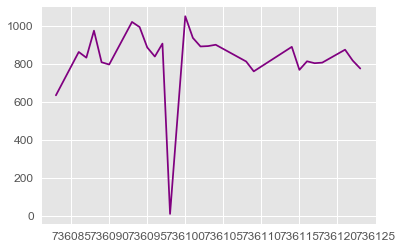

In [60]:
plt.plot(ts.groupby(['AppointmentDayOrdinal'])['NoShow'].sum(), color="purple")
plt.show

#### Task 2 (Response: Gender)

In [24]:
#Testing set --- hold 1 month of data out as test set based on AppointmentDay
df_test = df.copy()
# Calculation to find the ordinal value of AppointmentDay to split data at
X_test2 = df_test[df['AppointmentDayOrdinal'] >=  (max(df['AppointmentDayOrdinal'])- 
             (max(df['AppointmentDayOrdinal'])-(min(df['AppointmentDayOrdinal'])))* splitPerc)]
y_test2 = X_test2['IsMale'].values # get the labels we want.

if 'IsMale' in X_test2:
    del X_test2['IsMale'] # get rid of the class label

#Training set -- all records less than appointment date 5/1/2016
df_train = df.copy() 
                 
X_train2 = df_train[df['AppointmentDayOrdinal'] < (max(df['AppointmentDayOrdinal'])- 
             (max(df['AppointmentDayOrdinal'])-(min(df['AppointmentDayOrdinal'])))* splitPerc)]
y_train2 = X_train2['IsMale'].values # get the labels we want.
del X_train2['IsMale'] # get rid of the class label
if 'IsMale' in X_train2:
    del X_train2['IsMale'] # get rid of the class label

#All data
df_tmp = df.copy()
X2 = df_tmp
y2 = df_tmp['IsMale']
if 'IsMale' in X2:
    del X2['IsMale'] # get rid of the class label

In [25]:
print ('Number of Prediciting Features: ', X2.shape)
print ('Number of Response: ', y2.shape)
print ('Appointment Date Range (Trainig Set): ', min(X_train2['AppointmentDayOrdinal']) ," - ",  max(X_train2['AppointmentDayOrdinal']))
print ('Number of Training Records: ', "Predictors: ", X_train2.shape, "Response:" ,y_train2.shape)
print ('Number of Test Records: ', "Predictors: ",X_test2.shape, "Response:" ,y_test2.shape)
print ('Appointment Date Range (Test Set): ', min(X_test2['AppointmentDayOrdinal']) ," - ",  max(X_test2['AppointmentDayOrdinal']))

Number of Prediciting Features:  (110527, 115)
Number of Response:  (110527,)
Appointment Date Range (Trainig Set):  736083  -  736109
Number of Training Records:  Predictors:  (75283, 115) Response: (75283,)
Number of Test Records:  Predictors:  (35244, 115) Response: (35244,)
Appointment Date Range (Test Set):  736114  -  736123


#### Grid Search
<p>A grid search will help determine the optimal parameters to pass to the logistic regression function. Finding the optimal parameters will help with model prediction.</p>
<p>Some parameters are being selected as the only option due to the type of dataset. We will try using a solver with a default parameter 'lbfgs' for binomial problems, although sag and saga are faster for larger datasets.</p>
<p>The multi-class parameter is set to the default of 'ovr' because we have a binary problem.

In [26]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X2, y2, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X2, y2, scoring=['accuracy','precision','recall','f1']
                            , cv=cv_object, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()
    f1avg = scores['test_f1'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"
    print_str4 = "The average f1 for all cv folds is: \t\t\t {f1avg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print(print_str4.format(f1avg=f1avg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    scoresResults['f1'] = scores['test_f1']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X2, y2, cv_object):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X2, y2, cv=cv_object)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y2, predictions)
    confMat2 = confusion_matrix(y2, predictions)
    acc = accuracy_score(y2, predictions)
    
    print(classReport)
    print(confMat2)
    print(acc)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = LogisticRegression()
#commented out for expediency after gridsearch
#parameters = {'penalty':['l2']
 #             ,'C': [0.001, 0.01, 0.1, .5, 1, 10,100]
 #             ,'class_weight': [ 'none']
  #            ,'random_state': [123456789]
   #           ,'solver': ['lbfgs']
    #          ,'max_iter':[100,500,1000]
     #         }
             


parameters = {'penalty':['l2']
              ,'C': [1]
              ,'class_weight': [ 'none']
              ,'random_state': [123456789]
              ,'solver': ['lbfgs']
              ,'max_iter':[100]
              }
             
#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='f1'
                            )
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X2, y2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.0s remaining:    1.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [1], 'class_weight': ['none'], 'random_state': [123456789], 'solver': ['lbfgs'], 'max_iter': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [28]:
#Diplay the top model parameters
LRestimator2 = regGridSearch.best_estimator_
LRestimator2

LogisticRegression(C=1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123456789,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = RandomForestClassifier()
#commented out for expediency after gridsearch
#parameters = {'n_estimators':[10, 100, 1000],
#              'random_state':[123456789]
#              }

parameters = {'n_estimators':[10],
              'random_state':[123456789]
              }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='f1'
                            )
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X2, y2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    3.5s remaining:    2.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.8s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'n_estimators': [10], 'random_state': [123456789]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

<p>By performing a grid search, the best parameters to pass into the Logistic Regression are identified for us. Below is the best estimator parameters for class weight and cost without scaling the data. The optimal values were estimated to be 0.01 for C (100 times smaller than the default 1.0 value) and 500 for max_iter (5 times greater than the default value of 100).

In [30]:
#Diplay the top model parameters
RFestimator2 = regGridSearch.best_estimator_
RFestimator2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123456789, verbose=0,
            warm_start=False)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

regEstimator = XGBClassifier()


parameters = {
             }


#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds
                   , scoring='f1')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X2, y2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   21.6s remaining:   14.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   39.9s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=8, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [32]:
#Diplay the top model parameters
XGBestimator2 = regGridSearch.best_estimator_
XGBestimator2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# All

clf_array = [
    ('Logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)),
    ('Random Trees', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)),
    ('XGBoost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))
    ]
print('All Data')
for clf in clf_array:
    acc = cross_val_score(clf[1], X2, y2)
    
    print (clf[0], acc.mean())

All Data
Logistic 0.6499769288124675
Random Trees 0.646964182656485
XGBoost 0.669085391786314


In [34]:
# Train
print('Training Set')
for clf in clf_array:
    acc = cross_val_score(clf[1],X_train2,y_train2)
    
    print (clf[0], acc.mean())

Training Set
Logistic 0.6482738469139392
Random Trees 0.6380722887204126
XGBoost 0.6682118885775564


In [35]:
#Test
print('Testing Set')
for clf in clf_array:
    acc = cross_val_score(clf[1],X_test2,y_test2)
    
    print (clf[0], acc.mean())

Testing Set
Logistic 0.6536148004241641
Random Trees 0.6495570920476693
XGBoost 0.6718873756432718


## Modeling and Evaluation 4

##### Resubmission:

Classifier Comparison between two Binary Responses

When looking at the NoShow response, we have simular accuracy scores between the classification models.
With Precision, XG Boost shows to be a better classification model because it shows a higher percentage of positive predictions based on True No Shows.
The sensitivity metric called recall tells us that random forest model has a higher False negative prediction.
The F Measure is showing Random Forest as being the model with the best balance between precision and recall.

For the Gender response, accuracy, precision and recall are all closely aligned to each other. The F Measure would indicate that XG Boost to has the better balance between precision and recall.


| Response: **NoShow**                      |Logistic Regression | Random Forest | XGB        |
|-------------------------------------------|------------------- | ------------- | -----------|
|The average accuracy for all cv folds is: 	|	 0.79725         |   0.78356     |  0.79815   |
|The average precision for all cv folds is: |	 0.10834         |   0.3516      |  0.50397   |
|The average recall for all cv folds is: 	|	 0.004969        |   0.087257    |  0.0025519 |
|The average f1 for all cv folds is: 		|	 0.0094512       |   0.13904     |  0.0050485 |
|-------------------------------------------|------------------- | ------------- | -----------|

| Response: **Gender**                      |Logistic Regression | Random Forest | XGB        |
|-------------------------------------------|------------------- | ------------- | -----------|
|The average accuracy for all cv folds is: 	|	 0.65618         |   0.64441     |  0.67152   |
|The average precision for all cv folds is: |	 0.0             |   0.47577     |  0.5427    |
|The average recall for all cv folds is: 	|	 0.0             |   0.28668     |  0.29866   |
|The average f1 for all cv folds is: 		|	 0.0             |   0.35521     |  0.38294   |
|-------------------------------------------|------------------- | ------------- | -----------|

##### Confusion Matrix
With Logistic Regression, precision, recall and F Measure were not calculated because either true/false postitives and/or true/false negatives were not recorded. I suspect this has to do with the low number of appointments recorded earlier in the time-series versus later in the time series. Also, as indicated in Lab1, we have a 70/30 split of NoShows which can account for period of time which had no no shows.

##### ROC
The ROC confirms that we have a better than chance to predict a NoShow based on the XG Boost model with both response types.

| Response: **NoShow**  |Logistic Regression | Random Forest | XGB     |
|-----------------------|------------------- |-------------- | --------| 
|AUC                	|	 .54             |   0.67        |  0.72   |
|-----------------------|------------------- | ------------- | --------|
| Response: **Gender**  |Logistic Regression | Random Forest | XGB     |
|------------------------------------------- |-------------- | --------| 
|AUC                	|	 .50             |   0.63        |  0.66   |
|-----------------------|------------------- | ------------- | --------|

In [36]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(LRestimator, X, y, cv_object)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undef

The average accuracy for all cv folds is: 			 0.79725
The average precision for all cv folds is: 			 0.10834
The average recall for all cv folds is: 			 0.004969
The average f1 for all cv folds is: 			 0.0094512
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,f1
0,0.798248,0.000000,0.000000,0.000000
1,0.791281,0.000000,0.000000,0.000000
2,0.792575,0.000000,0.000000,0.000000
3,0.788892,0.294643,0.015904,0.030178
4,0.744600,0.000000,0.000000,0.000000
5,0.808301,0.000000,0.000000,0.000000
6,0.827212,0.269565,0.018419,0.034483
7,0.803623,0.000000,0.000000,0.000000
8,0.825321,0.519231,0.015367,0.029851
9,0.792475,0.000000,0.000000,0.000000


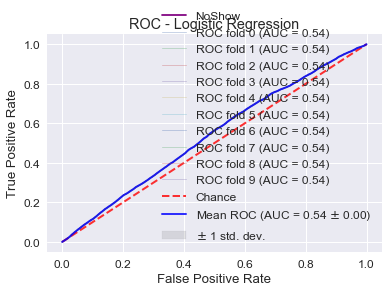

In [37]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


n_samples, n_features = X.shape


# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = cv_object
classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [38]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(RFestimator, X, y, cv_object)

The average accuracy for all cv folds is: 			 0.78356
The average precision for all cv folds is: 			 0.3516
The average recall for all cv folds is: 			 0.087257
The average f1 for all cv folds is: 			 0.13904
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall,f1
0,0.777048,0.322204,0.095215,0.146992
1,0.772768,0.330292,0.086314,0.136862
2,0.774659,0.352941,0.103647,0.160237
3,0.777247,0.351548,0.093012,0.147104
4,0.737534,0.443918,0.109509,0.175680
5,0.793570,0.357143,0.096054,0.151391
6,0.815069,0.330754,0.101604,0.155455
7,0.794068,0.364407,0.065383,0.110872
8,0.816164,0.361963,0.067160,0.113298
9,0.777446,0.300792,0.054676,0.092532


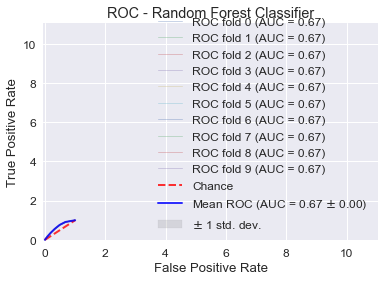

In [39]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = cv_object
classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 11.05])
plt.ylim([-0.05, 11.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [40]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(XGBestimator, X, y, cv_object)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The average accuracy for all cv folds is: 			 0.79815
The average precision for all cv folds is: 			 0.50397
The average recall for all cv folds is: 			 0.0025519
The average f1 for all cv folds is: 			 0.0050485
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall,f1
0,0.797452,0.333333,0.003947,0.007801
1,0.791580,0.540541,0.009537,0.018744
2,0.792873,0.600000,0.004319,0.008576
3,0.792774,0.315789,0.002892,0.005731
4,0.744202,0.250000,0.000779,0.001554
5,0.808301,0.500000,0.000519,0.001037
6,0.832487,0.500000,0.000594,0.001187
7,0.803822,1.000000,0.001014,0.002025
8,0.825122,0.000000,0.000000,0.000000
9,0.792873,1.000000,0.001918,0.003830


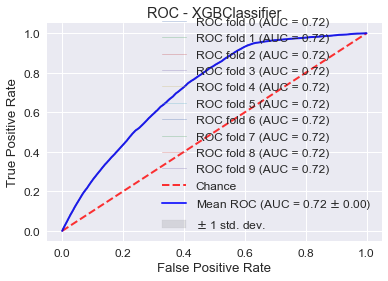

In [41]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = cv_object
classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - XGBClassifier')
plt.legend(loc="lower right")
plt.show()

In [42]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(LRestimator2, X2, y2, cv_object)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undef

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The average accuracy for all cv folds is: 			 0.65618
The average precision for all cv folds is: 			 0.0
The average recall for all cv folds is: 			 0.0
The average f1 for all cv folds is: 			 0.0
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,f1
0,0.655021,0.0,0.0,0.0
1,0.683289,0.0,0.0,0.0
2,0.646661,0.0,0.0,0.0
3,0.638599,0.0,0.0,0.0
4,0.637802,0.0,0.0,0.0
5,0.675127,0.0,0.0,0.0
6,0.646462,0.0,0.0,0.0
7,0.680999,0.0,0.0,0.0
8,0.646860,0.0,0.0,0.0
9,0.650941,0.0,0.0,0.0


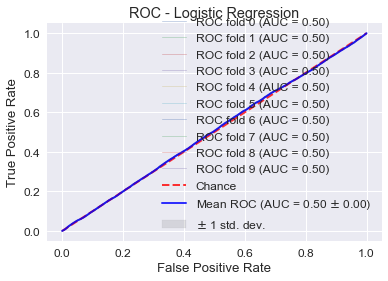

In [43]:
n_samples, n_features = X2.shape

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = cv_object
classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X2, y2):
    probas_ = classifier.fit(X_train2, y_train2).predict_proba(X_test2)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test2, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [44]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(RFestimator2, X2, y2, cv_object)

The average accuracy for all cv folds is: 			 0.64441
The average precision for all cv folds is: 			 0.47577
The average recall for all cv folds is: 			 0.28668
The average f1 for all cv folds is: 			 0.35521
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall,f1
0,0.610033,0.424161,0.364686,0.392181
1,0.668558,0.463366,0.294155,0.359862
2,0.648353,0.503869,0.311831,0.385244
3,0.634418,0.489362,0.266042,0.344692
4,0.645466,0.521259,0.259412,0.346422
5,0.639494,0.426398,0.317708,0.364115
6,0.642679,0.490857,0.287162,0.362345
7,0.652931,0.426715,0.256162,0.320140
8,0.647158,0.500904,0.234216,0.319186
9,0.655021,0.510841,0.275449,0.357910


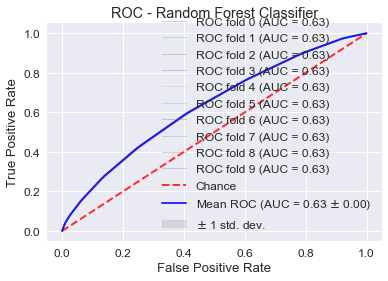

In [45]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = cv_object
classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X2, y2):
    probas_ = classifier.fit(X_train2, y_train2).predict_proba(X_test2)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test2, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [46]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(XGBestimator2, X2, y2, cv_object)

The average accuracy for all cv folds is: 			 0.67152
The average precision for all cv folds is: 			 0.5427
The average recall for all cv folds is: 			 0.29866
The average f1 for all cv folds is: 			 0.38294
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall,f1
0,0.656415,0.502572,0.394691,0.442146
1,0.704489,0.558229,0.320867,0.407503
2,0.668160,0.555441,0.304789,0.393598
3,0.654325,0.540347,0.291380,0.378601
4,0.659799,0.561491,0.277274,0.371229
5,0.681796,0.519002,0.280331,0.364034
6,0.666368,0.551493,0.301520,0.389880
7,0.683289,0.506322,0.287363,0.366640
8,0.666169,0.570700,0.220688,0.318293
9,0.674430,0.561394,0.307670,0.397495


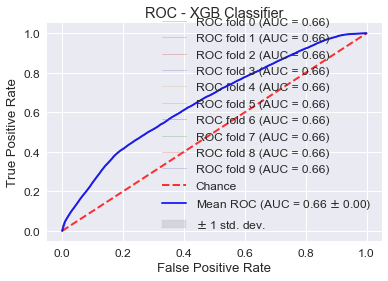

In [47]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = cv_object
classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X2, y2):
    probas_ = classifier.fit(X_train2, y_train2).predict_proba(X_test2)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test2, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - XGB Classifier')
plt.legend(loc="lower right")
plt.show()

## Modeling and Evaluation 5

Task 1 Accuracies (All Data):<br>
Logistic 0.79806744073009<br>
Random Trees 0.7796558116889997<br>
XGBoost 0.7974703138481137<br>
<br>
Task 2 Accuracies (All Data):<br>
Logistic 0.6499769288124675<br>
Random Trees 0.6465841776412136<br>
XGBoost 0.669085391786314<br>
<br>

Based on the previous accuracies calculated against all data in the dataset, the logistic and XGBoost models both performed better than random forest for task 1 (predicting NoShows). For task 2 (predicting Gender), XGBoost performed better than the others. This is an interesting pattern to observe, since both tasks involved the classification of a binary response variable, so we had expected that intuitively both tasks would perform the same relative to each model.

Nevertheless, it is important to verify these results statistically rather than just by anecdotal observation. To do this, we will calculate 95% confidence intervals for the difference in accuracy between the 2 models, as was described in the Unit 7.5 asynchronous materials.

In [48]:
# Define a function to calculate confidence interval for accuracy between 2 models 
import math
def diff_ci(acc1, acc2, n1=110527, n2=110527):
    """ Get a 95% CI of the difference in accuracy between 2 models given accuracy and n for each model."""
    e1 = 1.0 - float(acc1)
    e2 = 1.0 - float(acc2)
    var1 = (e1 * float(acc1)) / float(n1)
    var2 = (e2 * float(acc2)) / float(n2)
    ci_half_width = 1.96 * math.sqrt(var1 + var2)
    e_diff = e1 - e2
    ci = [e_diff - ci_half_width, e_diff + ci_half_width]
    return ci

# Task 1
print("Accuracies for Task 1 (NoShow Prediction)")
print("Logistic vs. RandomForest:", diff_ci(0.79806744073009, 0.7796558116889997))
print("Logistic vs. XGBoost:", diff_ci(0.79806744073009, 0.7974703138481137))
print("RandomForest vs. XGBoost:", diff_ci(0.7796558116889997, 0.7974703138481137))

Accuracies for Task 1 (NoShow Prediction)
Logistic vs. RandomForest: [-0.021813441476899117, -0.015009816605281449]
Logistic vs. XGBoost: [-0.003946004672715851, 0.0027517509087634155]
RandomForest vs. XGBoost: [0.014410873524419308, 0.021218130793808822]


As you can see from the above confidence intervals, Logistic and XGBoost are both significantly different in terms of prediction accuracy than RandomForest at 95% confidence level. However, XGBoost and Logistic both provide prediction accuracy that is not statistically different from each other at 95% confidence for task 1. Therefore, we can say that either XGBoost or Logistic regression is suitable for predicting NoShows.

In [49]:
# Task 2
print("Accuracies for Task 2 (Patient Gender Prediction)")
print("Logistic vs. RandomForest:", diff_ci(0.6499769288124675, 0.6465841776412136))
print("Logistic vs. XGBoost:", diff_ci(0.6499769288124675, 0.669085391786314))
print("RandomForest vs. XGBoost:", diff_ci(0.6465841776412136, 0.669085391786314))

Accuracies for Task 2 (Patient Gender Prediction)
Logistic vs. RandomForest: [-0.007373949611068579, 0.0005884472685607246]
Logistic vs. XGBoost: [0.015158391709425633, 0.02305853423826736]
RandomForest vs. XGBoost: [0.018546718709783583, 0.026455709580417264]


For task 2 (predicting Gender), Logistic and RandomForest were not statistically significantly different at 95% confidence level. However, XGBoost was shown to be more accurate than both models with 95% confidence.

Based on these results, it appears that XGBoost is the best overall model for predicting either NoShow or Gender.

## Modeling and Evaluation 6
We had six models all together (three with NoShow (Yes or No) as the Dependant Variable and three where Gender (Male or Female) is the Dependant variable.  To visually compare all of the models we used a standard scalar class to scale all of the variables to between -1 to 1 (or 0 to 1 depending on the plot).

Some interesting trends noticed are Age is a determining factor for predicting NoShows along with Scheduled Day and Time. A larger number of NoShow were detected in Lab 1 when looking at correlation between features and response variable in Lab 1.
When prediciting Gender, Scholarship, Age, Days In Advance and Alcolism are strong influence.

An interesting note is the each of the models (Logistic, Random Forests, XG boost) each preferred similar features despite the dependant variable and tended to focus on those.

___

In [50]:
# plot libraries & Setup
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from matplotlib import pyplot as plt

Model 1: NoShow as the Dependant Variable using Logistic Regression.  As per this model, the features that affected the model most as to whom would be a NoShow: Age (negative meaning the younger the more likely to not show up) as well as the Sheduled day ordinal, indicating that lower the day ordinal, the more likley of a NoShow (negativethis can be corraborated in our Lab 1 where there were more NoShows on Tuesday and Wednesday as opposed to Thursday and Friday); On the positive side, if an SMS were received and The numbers of Days in Advanced also affected the model.  On the other extreme, Variables such as Gender (isMale), handicaps, Diabetes, and most neighborhoods did not really have much of a difference.

NoShow Logistic Regression Weights


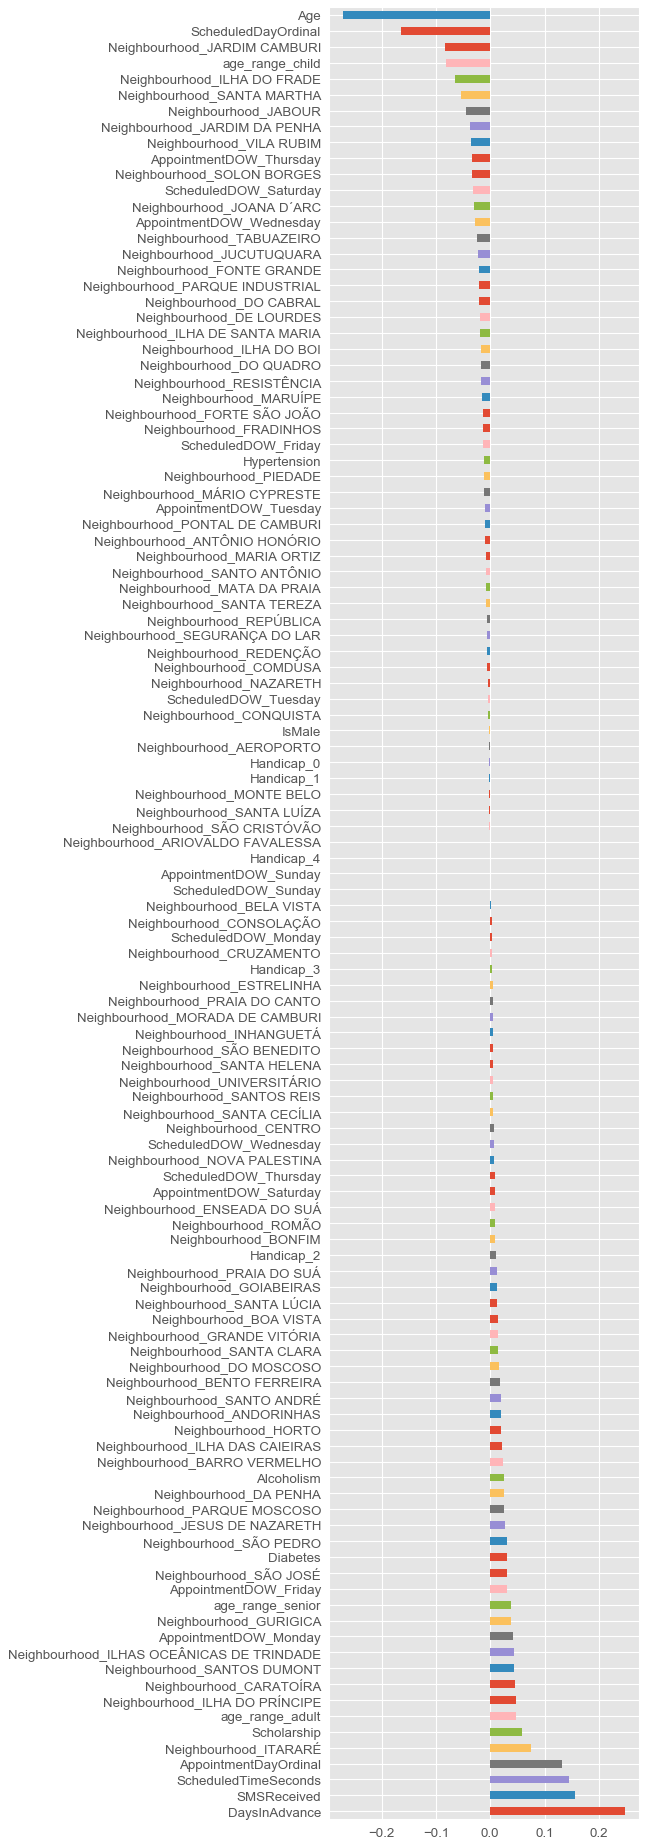

In [51]:
# NoShow Logistic Regression

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# Fit the models with the data
lr_clf = clf_array[0][1]
lr_clf.fit(X_train_scaled,y_train)  # train object
y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

# Organize data for plotting
df3 = pd.DataFrame(lr_clf.coef_[0],X.columns)
df3 = df3.sort_values([0],ascending=False)

# Plot
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(5, 30), dpi=80)

weights = pd.Series(df3[0],df3[0].index)
weights.plot(kind='barh')
print('NoShow Logistic Regression Weights')

plt.show()

---
Model 2: Gender as the Dependant Variable using Logistic Regression.  As per this model, the features that affected the model most as to weather the person would be a Male or Female tended to be if the were part of the Scholarship program (In this case though only 10% of the subjects received the scholarship, 82% of those were female), while another negative indicator or indicator that would indicate a female were the age range of an adult of senior.  On the other hand, in terms of better predicting a male, Alcoholism would play a big part (which corroberates the fact that although only 3% of the people reported alcoholism, 64% were male) also the average age rate for females was higher than males so the lower age ranges tended to favor males.

Gender Logistic Regression Weights


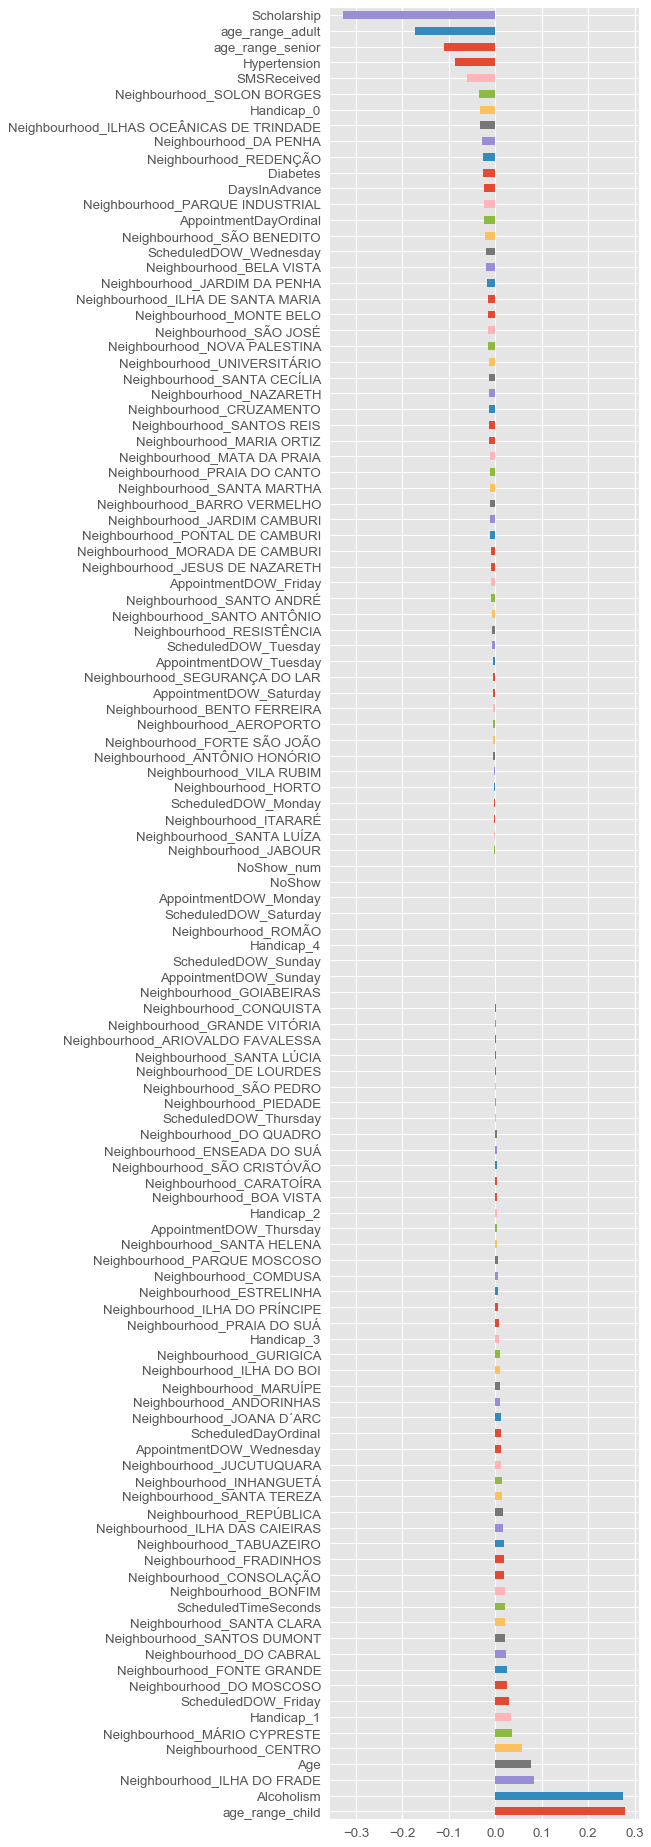

In [52]:
# Gender Logistic Regression

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train2) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train2) # apply to training
X_test_scaled = scl_obj.transform(X_test2) # apply those means and std to the test set (without snooping at the test set values)

# Fit the models with the data
lr_clf = clf_array[0][1]
lr_clf.fit(X_train_scaled,y_train2)  # train object
y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

# Organize data for plotting
df3 = pd.DataFrame(lr_clf.coef_[0],X2.columns)
df3 = df3.sort_values([0],ascending=False)

# Plot
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(5, 30), dpi=80)

weights = pd.Series(df3[0],df3[0].index)
weights.plot(kind='barh')
print('Gender Logistic Regression Weights')

plt.show()

___
Model 3: NoShow as the Dependant Variable using Random Forest.  As per this model, the features that affected the model most  in order were The time of schedule, age of the individial, Days in advance for scheduling, and the day schedule while the least were handicaps.  This is not exact, but shows that generally the same features had similar effects on Logistic and Random Forests.

NoShow Random Forest Regression Weights


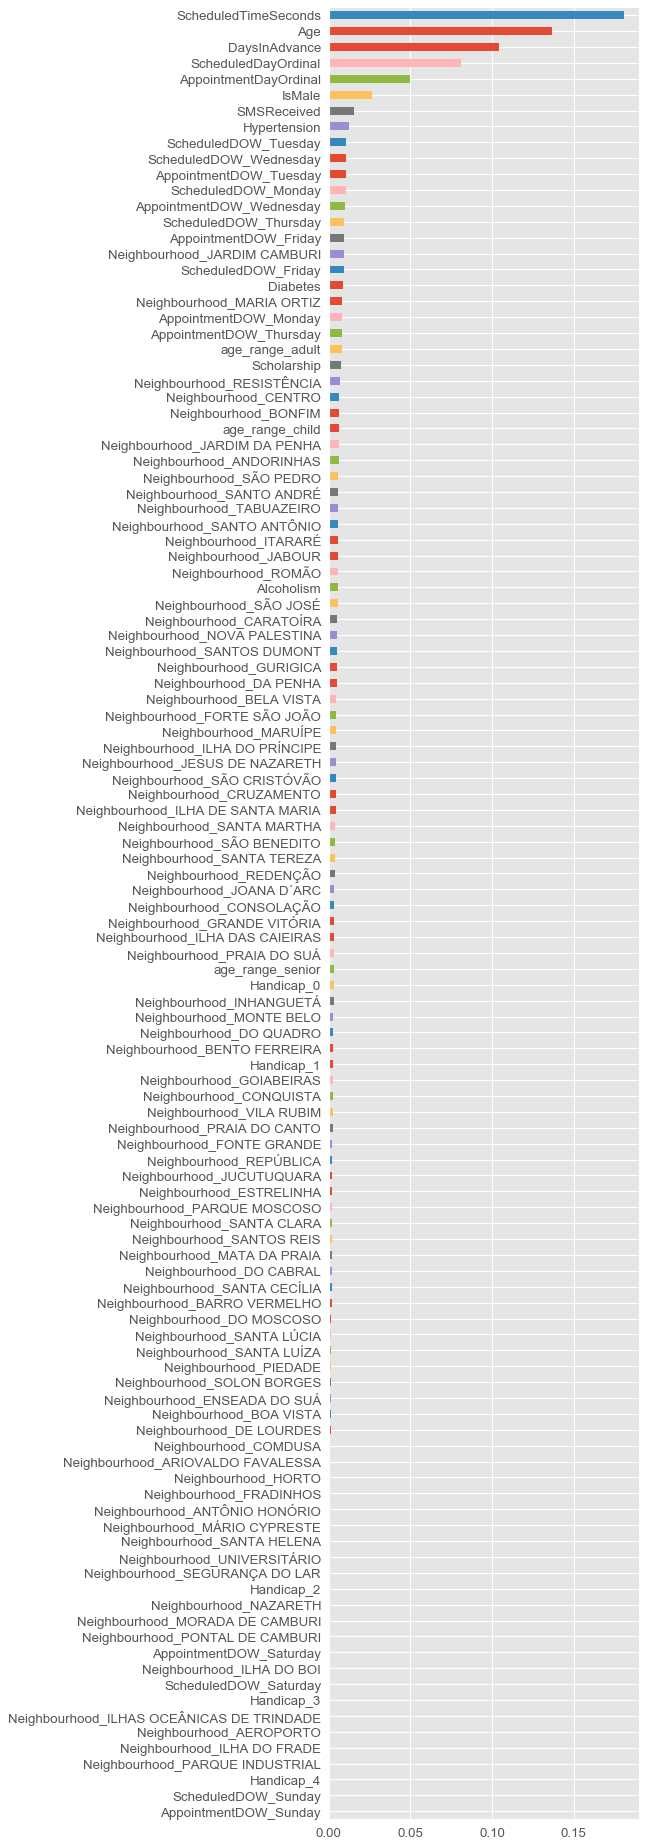

In [53]:
# NoShow Random Forest Regression

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# Fit the models with the data
rf_clf = clf_array[1][1]
rf_clf.fit(X_train_scaled,y_train)  # train object
y_hat = rf_clf.predict(X_test_scaled) # get test set precitions

# Organize data for plotting
df3 = pd.DataFrame(rf_clf.feature_importances_,X.columns)
df3 = df3.sort_values([0],ascending=True)

# Plot
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(5, 30), dpi=80)

weights = pd.Series(df3[0],df3[0].index)
weights.plot(kind='barh')
print('NoShow Random Forest Regression Weights')

plt.show()

---
Model 4: Gender as the Dependant Variable using Random forests.  As per this model, the features that affected the model most as to weather the person would be a Male or Female tended to be if the were part of the Schedule time, age, day, and the days in advanced scheduled.  This seems similar to the previous  Model 3 with Random forests for NoShow as opposed to the Logistic Regression for predicting Gender.  This could be that the other variables with Random forests do provide any information.

In [54]:
# Gender Random Forest Regression

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train2) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train2) # apply to training
X_test_scaled = scl_obj.transform(X_test2) # apply those means and std to the test set (without snooping at the test set values)

Gender Random Forest Regression Weights


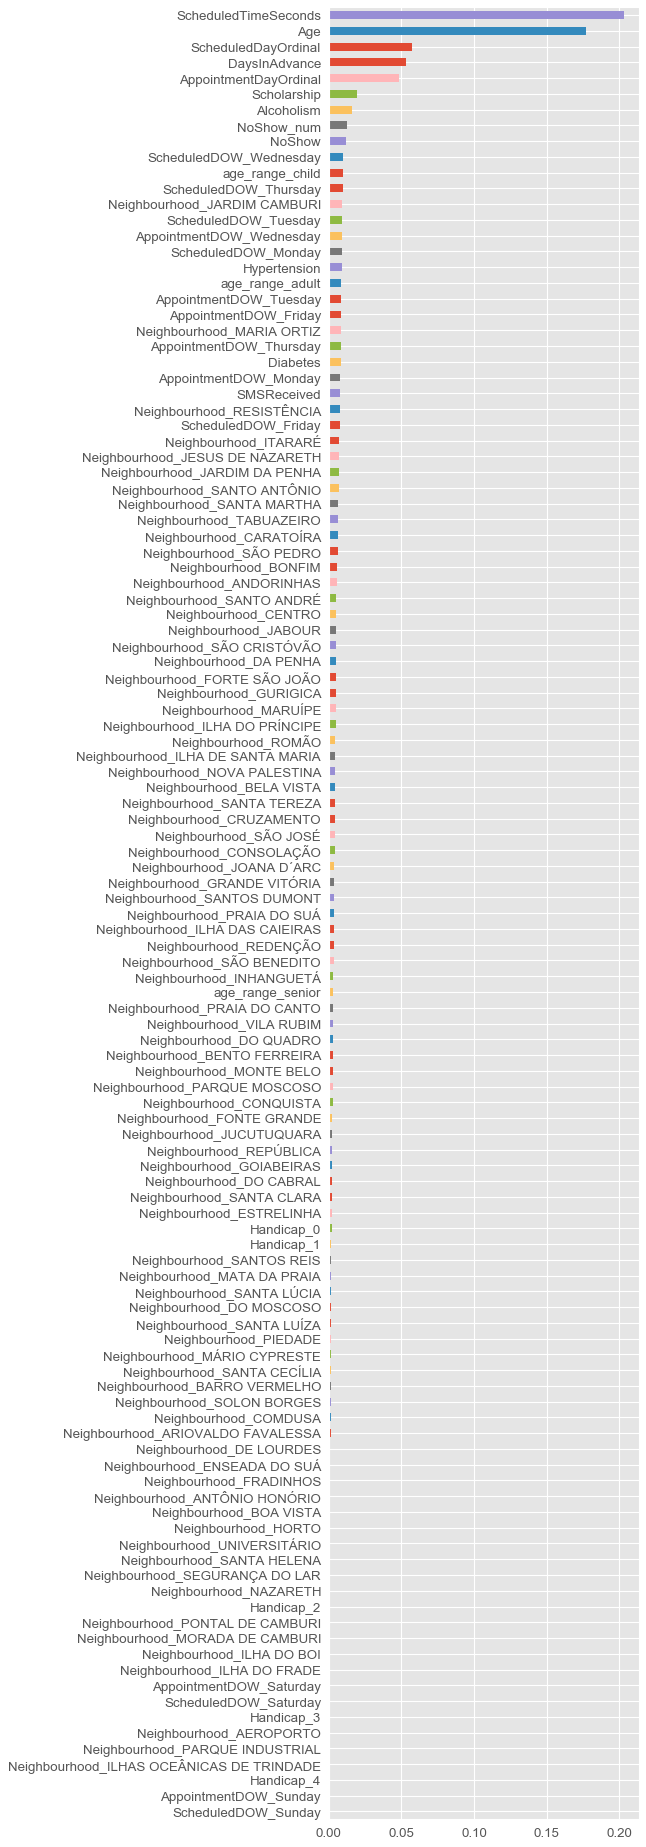

In [55]:
# Fit the models with the data
rf_clf = clf_array[1][1]
rf_clf.fit(X_train_scaled,y_train2)  # train object
y_hat = rf_clf.predict(X_test_scaled) # get test set precitions

# Organize data for plotting
df3 = pd.DataFrame(rf_clf.feature_importances_,X2.columns)
df3 = df3.sort_values([0],ascending=True)

# Plot
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(5, 30), dpi=80)

weights = pd.Series(df3[0],df3[0].index)
weights.plot(kind='barh')
print('Gender Random Forest Regression Weights')

plt.show()

---
Model 5: The NoShow XG Boost Regression tends to use similar features to Random Forests but use, as in order, Age as the most important, Days In Advances, Scheduled time, Scheduled days, while most else of lesser importance.

NoShow XG Boost Regression Weights


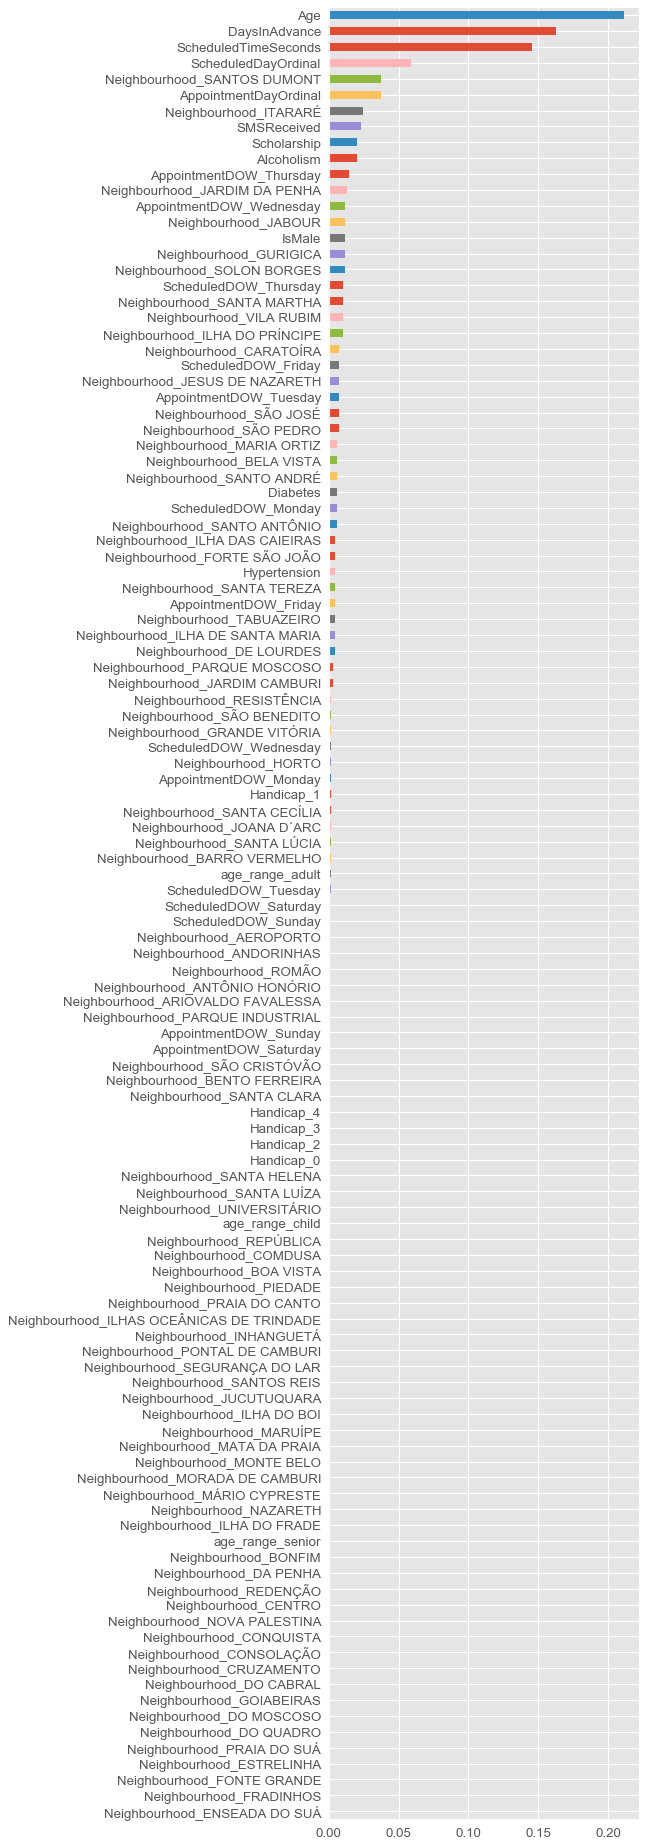

In [56]:
# NoShow XG Boost Regression

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# Fit the models with the data
xg_clf = clf_array[2][1]
xg_clf.fit(X_train_scaled,y_train)  # train object
y_hat = xg_clf.predict(X_test_scaled) # get test set precitions

# Organize data for plotting
df3 = pd.DataFrame(xg_clf.feature_importances_,X.columns)
df3 = df3.sort_values([0],ascending=True)

# Plot
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(5, 30), dpi=80)

weights = pd.Series(df3[0],df3[0].index)
weights.plot(kind='barh')
print('NoShow XG Boost Regression Weights')

plt.show()

---
Model 6: The Gender XG Boost Regression tends to use similar features to the previous NoShow but use, as in order, Age as the most important, Scheduled time, Scholarship (kind of like the logistic regression), Days In Advanced, and Alcoholism, while most else of lesser importance.

Gender XG Boost Regression Weights


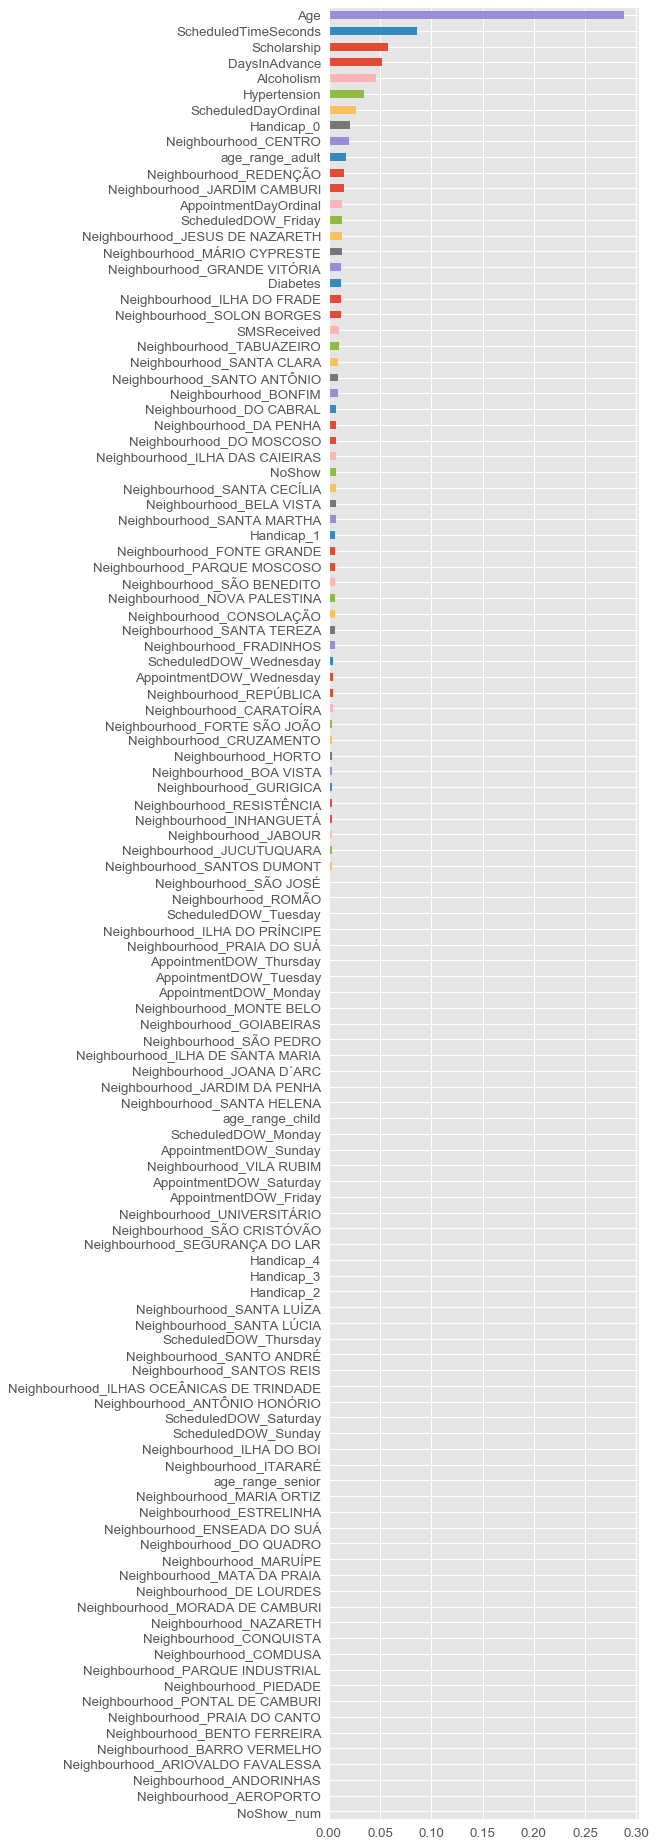

In [57]:
# Gender XG Boost Regression

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train2) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train2) # apply to training
X_test_scaled = scl_obj.transform(X_test2) # apply those means and std to the test set (without snooping at the test set values)

# Fit the models with the data
xg_clf = clf_array[2][1]
xg_clf.fit(X_train_scaled,y_train2)  # train object
y_hat = xg_clf.predict(X_test_scaled) # get test set precitions

# Organize data for plotting
df3 = pd.DataFrame(xg_clf.feature_importances_,X2.columns)
df3 = df3.sort_values([0],ascending=True)

# Plot
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(5, 30), dpi=80)

weights = pd.Series(df3[0],df3[0].index)
weights.plot(kind='barh')
print('Gender XG Boost Regression Weights')

plt.show()

## Deployment (5 points total) 

#### Resubmission:

#### Task1 model – No show
For our first model the random forest model appears to be providing the highest f1 score for predicting no-show. In a practical sense the random forest model performs fairly close to the XGBoost algorithm

#### Task 2 model - Gender relative to No show
For our 2nd task model the XGBoost model appears to be providing the highest f1 score for predicting no-show. In a practical sense the XGBoost model performs fairly close to the other algorithms.


##### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? 
Currently the Random Forest and XGBoost model have the most promising results from our developed models. In practice, our results likely wouldn't meet the standards of a clinical manager or medical provider in the sense that deploying the models will generate many false positive results and will quickly upset patients and medical providers when a day occurs with too many false positive no-show predictions that result in heavy overbooking. From a business standpoint, if a clinical leader was to overbook for predicted no show, the results from these models would result in far too many overbookings in most clinical environments and would likely quickly lead to the efforts cancelation. 

However, our models do have a practical application to these care centers. Clinical offices could potential deploy these models and use predicted no-show values to follow up with patients identified as being at risk of no-show before their visit and ensure the patient is still planning to come. While this would generate extra work for non-clinical office staff, model performance could be tuned to appropriate levels of yield based off available work time for staff. This could potentially allow the office to prevent some of the no-shows or open up slots for patients who want to get in as soon as possible for care by further investigating predicted no-show patients.

#### How would you measure the model's value if it was used by these parties? 
In practice, the best way to measure performance for business leaders is the amount of Correct no-show predictions relative to false positive no-show predictions. F1 score & recall are extremely useful metrics for data scientist as it gives a good understanding for this particular use case as mentioned in previous sections, but this would likely not be understood by our parties. Because of this, explaining actual positive no show predictions along with false positive no-show predictions is likely the most practical, albeit, unrefined method of communicating results.

#### How would you deploy your model for interested parties? 
To properly deploy our model, a dashboard or mechanism for displaying patient records before there appointment (likely 1-2 days in advance) would need to be deployed so clinical office workers could see patients predicted as no-shows and begin to follow up with the patient for that appointment. This might mean including patient contact information based off the patient records or making an easy link to a secondary system to allow staff to contact the predicted no-show patient. Upon follow up, it would be wise to document the outcome of the follow-up to potentially allow further level of predictions for future work. For example, patients who do not respond may be modeled with this interaction as a variable to further give confidence to a potential no-show through a secondary model giving the clinical leaders a potential green light to overbook). 

#### What other data should be collected? 
Distance from office would add another layer to the dataset that would help identified how far someone is form the office. Housing location would also add an interesting layer in that it could be combined with other things such as transportation access or traffic issues through other data sources to further improve predictions. Along with SMS alerts, I would gather email and phone call reminders notification to better understand the patient's behavioral trends.

#### How often would the model need to be updated, etc.? 
If possible, a quarterly refresh would be ideal in that it would allow for capturing updates to patient behavior, and if the model was expanded to include patient history as a variable, would allow for a more accurate prediction at the patient level. Otherwise, a yearly update may be reasonable if resources were constrained.

## Exceptional Work (10 points total)

For excceptional work, we performed grid search to help us optimize our resutls. This was performed in section Modeling and Evaluation 3 section.

As a further step, we used an uncovered modeling algorithm, xgboost, for this assignment. We feel that this would merit some level of exceptional work.

#### SMOTE

In [58]:
# Over-sampling using SMOTE to balance the NoShows
from imblearn.over_sampling import SMOTE
#Training set -- all records less than appointment date 5/1/2016
df_train = df.copy()
X_train = df_train

y_train = X_train['NoShow'].values # get the labels we want.
del X_train['NoShow'] # get rid of the class label

if 'NoShow' in X_train:
    del X_train['NoShow'] # get rid of the class label

sm = SMOTE()
X_train_ovr, y_train_ovr = sm.fit_sample(X_train, y_train.ravel())
print("Proportion of response in train set using SMOTE")
for i in np.unique(y_train) :
    print("The number of {} is {} accouting for {}%.".format(i, np.bincount(y_train)[i], np.round(np.bincount(y_train)[i]/len(y_train), 3)*100 ))

for i in np.unique(y_train_ovr) :
    print("The number of {} is {} accouting for {}%.".format(i, np.bincount(y_train_ovr)[i], np.round(np.bincount(y_train_ovr)[i]/len(y_train_ovr), 3)*100 ))


Proportion of response in train set using SMOTE
The number of False is [] accouting for []%.
The number of True is [[88208 22319]] accouting for [[79.8 20.2]]%.
The number of False is [] accouting for []%.
The number of True is [[88208 88208]] accouting for [[50. 50.]]%.


In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# All

clf_array = [
    ('Logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)),
    ('Random Trees', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)),
    ('XGBoost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))
    ]
print ('All Data: ')
for clf in clf_array:
    acc = cross_val_score(clf[1], X_train_ovr, y_train_ovr)

    print (clf[0], acc.mean())

All Data: 
Logistic 1.0
Random Trees 0.9585402964719679
XGBoost 1.0
